[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/060_attention/attention.ipynb)

# Transformers - Atención

Si hay un tema candente en el mundo del *Deep Learning* a día de hoy, ese es sin duda el de los *Transformers*. Desde que esta arquitectura de redes neuronales fue introducida en 2017 en el artículo [*Attention is all you need*](https://arxiv.org/abs/1706.03762) nuevas aplicaciones aparecen cada día en diferentes campos, mejorando el *state of the art*. Si bien el mayor impacto de los *Transformers* se ha visto en el campo del procesado de lenguaje natural, su aplicación en otros dominios (como el de la visión artificial) no hace más que crecer. Es debido a esta situación que me pregunto, ¿pero qué es un *Transformer*?, ¿cómo funiona?, ¿en qué se diferencia de otras arquitecturas como redes convolucionales o recurrentes? Con el objetivo de dar respuesta a estas preguntas, y muchas otras que surgirán por el camino, inicio una serie de posts para entender si realmente es oro todo lo que reluce.

## *Attention is all you need*

Como comentaba en el párrafo anterior, la arquitectura *Transformer* hizo su aparición a escena en 2017 gracias al artículo [*Attention is all you need*](https://arxiv.org/abs/1706.03762). El *paper* empieza así...

> *The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely.*

lo que traducido sería algo así como...

> *Los modelos secuenciales de transducción dominantes están basados en redes neuronales recurrentes o convolucionales complejas, las cuales incluyen un codificador y un decodificador. Los mejores modelos, además, conectan el codificador y el decodificador mediante un mecanismo de atención. Proponemos una nueva arquitectura simple, el Transformer, basado solamente en mecanismos de atención, haciendo innecesario el uso de recurrencia o convoluciones*

A grandes rasgos, podemos ver que efectivamente se trata de una nueva arquitectura basada en algo llamado `mecanismos de atención`, y que no utiliza ni convoluciones ni recurrencia. En [este](https://sensioai.com/blog/041_attention) post ya hablamos sobre este tema, sin embargo vamos ahora a entrar en detalle sobre lo que significa `atención` y como se implementa.

## ¿Qué es la atención?

Un mecanismo de atención, en el contexto de las redes neuronales, consiste en una operación matemática que recibe como *inputs* un conjunto de vectores (que ya sabemos que pueden representar texto, imágenes o cualquier tipo de datos con el que trabajemos) y nos da como resultado otro conjunto de vectores. Este resultado dependerá, obviamente, del tipo de mecanismo de atención que utilizemos. Vamos a ver algunos ejemplos.

### *Hard attention*

El mecanismo de atención más sencillo de entender es el conocido como *hard attention mechanism*. En este tipo de atención generaremos un número de vectores a la salida igual a los de la entrada (de ahora en adelante asumiremos que este es siempre el caso a no ser que se indique lo contrario) en el que cada *output* atenderá únicamente a su correspondiente vector a la entrada. O dicho de otra forma, este mecanismo de atención no produce nada nuevo, produce a la salida lo mismo que recibe a la entrada. Considera el conjunto de vectores siguiente.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X = torch.tensor([[1, 0],[0, 1], [-0.5, -0.5]])
X

tensor([[ 1.0000,  0.0000],
        [ 0.0000,  1.0000],
        [-0.5000, -0.5000]])

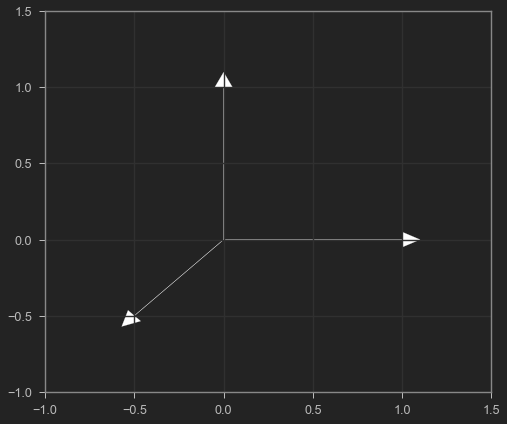

In [5]:
def plot_vectors(X, y=None):
    ax = plt.axes()
    plt.grid()
    for x in X:
        ax.arrow(0, 0, x[0], x[1], head_width=0.1, head_length=0.1, color="white")
    if y is not None:
        for _y in y:
            if _y.sum() != 0:
                ax.arrow(0, 0, _y[0], _y[1], head_width=0.1, head_length=0.1, color='red')
    plt.xlim(-1,1.5)
    plt.ylim(-1,1.5)
    plt.show()

plot_vectors(X)

Un mecaniso de *hard attention* presatará atención 😉 a un único vector. Podemos representarlo como un vector en el que, en cada posición, tenemos el peso relativo de cada vector a la entrada. En este caso, todos los valores serán 0 excepto el que se encuentre en la mismo posición del vector al que queremos prestar atención.

In [6]:
# hard attention (a es one hot)
# atendemos al primer vector 
a = torch.tensor([1, 0, 0])
a

tensor([1, 0, 0])

Para aplicar nuestro mecanismo de atención, simplemente multiplicamos nuestro conjunto de vectores por el vector de atención.

In [7]:
# todos los vectores en la salida son 0, excepto al que hemos prestado atención

y = a.unsqueeze(1) * X
y

tensor([[1., 0.],
        [0., 0.],
        [-0., -0.]])

Podemos ver en rojo la salida de nuestro mecanismo de atención fuerte cuando atendemos al primer vector (es, efectivamente, igual al primer vector). Hemos prestado atención únicamente a un elemento del conjunto, deshechando el resto.

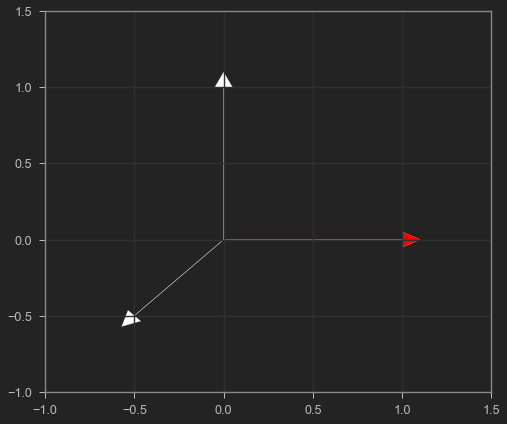

In [8]:
plot_vectors(X, y)

Podemos aplicar este mecanismo en una sola operación a todos los vectores generando una matriz de atención. En el caso de *hard attention*, esta matriz es la identidad.

In [9]:
A = torch.eye(3)
A

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

Multiplicando nuestra matriz de atención por la matriz que contiene todos los vectores de entrada, obtenemos los vectores de salida. En este caso, repetimos, obtendremos exactamente el mismo conjunto de vectores ya que cada vector a la salida atiene únicamente a un vector a la entrada, aquel que está en su misma posición. 

In [10]:
Y = A @ X
Y

tensor([[ 1.0000,  0.0000],
        [ 0.0000,  1.0000],
        [-0.5000, -0.5000]])

In [11]:
def plot(X, Y):
    fig = plt.figure(figsize=(15,4))
    for i, (x, y) in enumerate(zip(X, Y)):
      ax = plt.subplot(1, 3, i + 1)
      for x in X:
          ax.arrow(0, 0, x[0], x[1], head_width=0.1, color="white", head_length=0.1)
      ax.arrow(0, 0, y[0], y[1], head_width=0.1, head_length=0.1, color='red')
      ax.set_xlim(-1,1.5)
      ax.set_ylim(-1,1.5)
      ax.grid(True)
      ax.set_title(f"Atiende a {X[i].tolist()}")
    plt.tight_layout()
    plt.show()

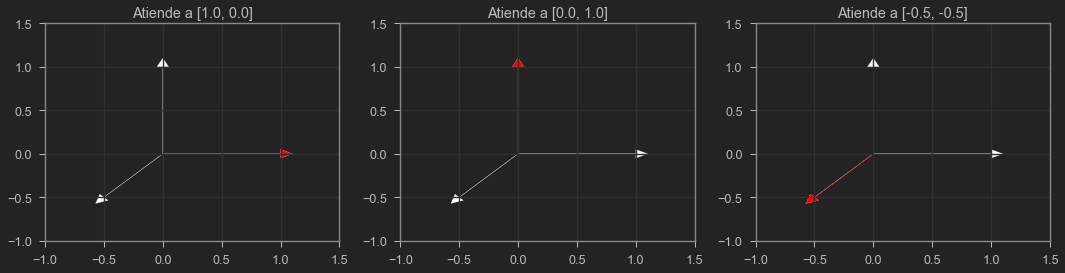

In [12]:
plot(X, Y)

## *Soft attention*

Ahora que hemos explicado qué es un mecanismo de atención y visto un ejemplo sencillo, vamos a ver otro tipo de mecanismo un poco más flexible. Si en el caso de la atención fuerte, cada vector generado presta atención simplemente a un único vector en la entrada, en el caso de la atención débil vamos a permitir prestar atención a todos los vectores a la entrada. Así pues, cada vector generado será una combinación de los *inputs*. En el siguiente ejemplo, cada vector generado presta un 80% de atención al vector en la entrada en su misma posición y un 10% al resto.

In [13]:
# soft attention (cada fila suma 1)

A = torch.ones((3, 3))*0.1
A.fill_diagonal_(0.8)
A

tensor([[0.8000, 0.1000, 0.1000],
        [0.1000, 0.8000, 0.1000],
        [0.1000, 0.1000, 0.8000]])

In [14]:
Y = A @ X
Y

tensor([[ 0.7500,  0.0500],
        [ 0.0500,  0.7500],
        [-0.3000, -0.3000]])

In [15]:
def plot(X, Y):
    fig = plt.figure(figsize=(15,4))
    for i, (x, y) in enumerate(zip(X, Y)):
      ax = plt.subplot(1, 3, i + 1)
      for x in X:
          ax.arrow(0, 0, x[0], x[1], color="white", head_width=0.1, head_length=0.1)
      Z = A[i].unsqueeze(1) * X
      for z in Z:
        ax.arrow(0, 0, z[0], z[1], head_width=0.1, head_length=0.1, color='green')
      ax.arrow(0, 0, y[0], y[1], head_width=0.1, head_length=0.1, color='red')
      ax.set_xlim(-1,1.5)
      ax.set_ylim(-1,1.5)
      ax.grid(True)
      ax.set_title(f"Atiende a {X[i].tolist()}")
    plt.tight_layout()
    plt.show()

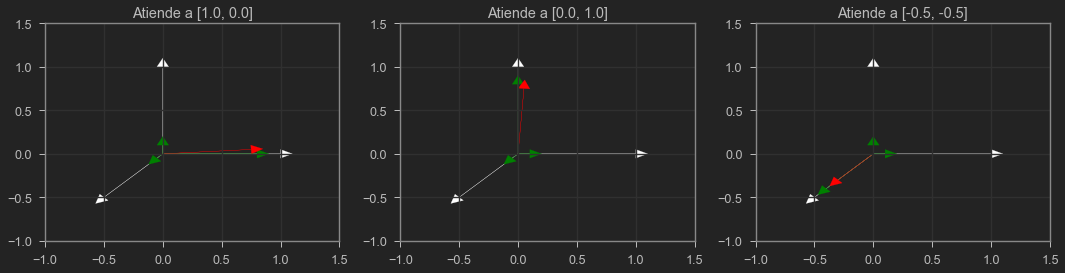

In [16]:
plot(X, Y)

En verde puedes ver la contribución de cada vector al resultado, mientras que en rojo puedes ver los vectores generados por nuestro mecanismo de atención. En este caso, son muy similares a los originales ya que estamos prestando mucha atención a éstos mismo. Sin embargo, el resto de vectores pueden influir en el resultado. Vamos ahora a prestar igual atención a todos los vectores.

In [17]:
A = torch.ones((3, 3))*(1./3.)
A

tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])

In [18]:
Y = A @ X
Y

tensor([[0.1667, 0.1667],
        [0.1667, 0.1667],
        [0.1667, 0.1667]])

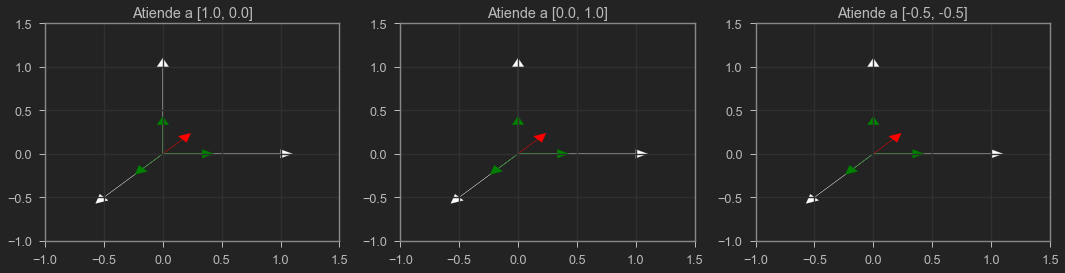

In [19]:
plot(X, Y)

En este caso, todos los vectores generados son iguales. La pregunta ahora es, ¿cuánta atención debe un vector prestar al resto? La respuesta es sencilla...*Self attention* !

### *Self attention*

En este último mecanismo de atención que veremos, cada vector es responsable de decidir por si mismo cuánta atención prestar al resto. Para ello calcularemos la similitud entre vectores. Cuanto más parecidos sean dos vectores, más atención habrá entre ellos y viceversa. En una tarea de traducción de texto, por ejemplo, a la hora de generar una palabra un mecanismo de *self attention* permitiría prestar más atención a aquellas palabras más relacionadas a la entrada, y no desperdiciar computación con aquellas que no tienen importancia. Esta similitud la calculamos multiplicando los vectores por si mismos y aplicando una función softmax.

In [20]:
# self attention -> similitud de cada vector con el resto

A = torch.softmax(X @ X.T, 1)
A

tensor([[0.6285, 0.2312, 0.1402],
        [0.2312, 0.6285, 0.1402],
        [0.2119, 0.2119, 0.5761]])

In [21]:
Y = A @ X
Y

tensor([[ 0.5584,  0.1611],
        [ 0.1611,  0.5584],
        [-0.0761, -0.0761]])

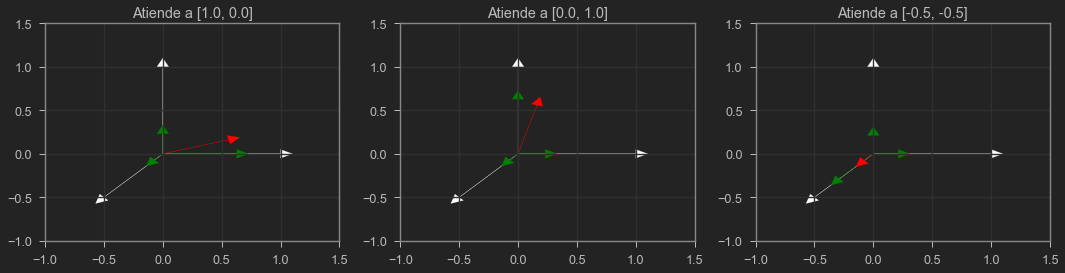

In [22]:
plot(X, Y)

## Resumen

En este post hemos visto uno de los principales conceptos a la hora de trabajar con *Transoformers*: los mecanismos de atención. Hemos aprendido que estos mecanismos reciben conjuntos de vectores a su entrada y son responsables de generar otro a su salida. Este resultado dependerá del mecanismo. En *hard attention*, cada vector generado presta atención únicamente a un vector (aquel que se encuentra en su misma posición a la entrada). En *soft attention* generamos vectores que son combinaciones de todos los vectores a la entrada. Por último, un mecanismo de *self attention* no es más que un mecanismo de *soft attention* en el que la importancia de cada vector a la entrada depende de la similitud entre este y el resto de *inputs*. En los posts siguientes seguiremos adentrándonos en el mundo de los *Transformers*, viendo otros conceptos importantes y sus implementaciones en Pytorch.